In [446]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import boxcox, normaltest
from sqlalchemy import create_engine
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [447]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

# Life Expectancy Challenge
> With this challenge, we attempt to find the factors that affect the life expectancy, specifically, **which factors increase the expected life in the countries and which factors decrease it**. This data was collected from the websites of the World Health Organisation (WHO) and World Bank (WB) as well as coutry population data I pulled from [photius.com](https://photius.com/rankings/population/population_2012_0.html) for reference purposes. Let's get started!

In [448]:
life.nunique()

Country                             193
Year                                 16
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
percentage expenditure             2328
Hepatitis B                          87
Measles                             958
 BMI                                608
under-five deaths                   252
Polio                                73
Total expenditure                   818
Diphtheria                           81
 HIV/AIDS                           200
GDP                                2490
Population                         2278
 thinness  1-19 years               200
 thinness 5-9 years                 207
Income composition of resources     625
Schooling                           173
dtype: int64

> We can see that the data spans 16 years and 193 countries. There are only two diffent `status` classes, 'Developed' and 'Developing, as we'll confirm shortly. The rest of the variable contains a large range of different values.

In [449]:
life.Status.unique()

array(['Developing', 'Developed'], dtype=object)

In [450]:
life.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


> Judging from the mean and std rows of the table, we can see that about two thirds of the countries have a life expectancy that falls roughly between 60 and 80 years. Given some of the min values of zero in various columns, at first glance it appears as if this data will have a lot of missing or erroneous values.

In [451]:
life.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

> The range index is 2938 entries which indicates that we have some NaN values to correct in some of our columns.

# Filling/Deleting missing values
+ The comments of each cell explain what the cell is accomplishing.

In [452]:
# Renaming the dataframe columns then sorting columns by country and then by year
life.columns = life.columns.str.strip().str.lower()

life = life.sort_values(['country', 'year'], ascending=True)
life.reset_index(drop=True, inplace=True)

life.head()

,country,year,status,life expectancy,adult mortality,infant deaths,alcohol,percentage expenditure,hepatitis b,measles,...,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
0,Afghanistan,2000,Developing,54.8,321.0,88,0.01,10.424960,62.0,6532,...,24.0,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5
1,Afghanistan,2001,Developing,55.3,316.0,88,0.01,10.574728,63.0,8762,...,35.0,7.80,33.0,0.1,117.496980,2966463.0,2.1,2.4,0.340,5.9
2,Afghanistan,2002,Developing,56.2,3.0,88,0.01,16.887351,64.0,2486,...,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,2.2,0.341,6.2
3,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.089053,65.0,798,...,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
4,Afghanistan,2004,Developing,57.0,293.0,87,0.02,15.296066,67.0,466,...,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8


In [453]:
# Deleting countries without values for our target variable, 'life expectancy'
life = life.dropna(subset=['life expectancy'])

# Notice ten countries have been deleted
life.nunique().head(1)

country    183
dtype: int64

In [454]:
# Missing value number and type detection
for column_name in life.columns[3:]:
    nan_list = []
    print("These are the problematic values for the variable: {}".format(column_name))
    for idx, value in enumerate(life[column_name]):
        if np.isnan(value):
            nan_list.append(str(value))
    print(len(nan_list), ': ', set(nan_list))
print(len(life))

These are the problematic values for the variable: life expectancy
0 :  set()
These are the problematic values for the variable: adult mortality
0 :  set()
These are the problematic values for the variable: infant deaths
0 :  set()
These are the problematic values for the variable: alcohol
193 :  {'nan'}
These are the problematic values for the variable: percentage expenditure
0 :  set()
These are the problematic values for the variable: hepatitis b
553 :  {'nan'}
These are the problematic values for the variable: measles
0 :  set()
These are the problematic values for the variable: bmi
32 :  {'nan'}
These are the problematic values for the variable: under-five deaths
0 :  set()
These are the problematic values for the variable: polio
19 :  {'nan'}
These are the problematic values for the variable: total expenditure
226 :  {'nan'}
These are the problematic values for the variable: diphtheria
19 :  {'nan'}
These are the problematic values for the variable: hiv/aids
0 :  set()
These are 

In [455]:
# Missing value number and type and country detection
for column_name in life.columns[3:]:
    nan_list = []
    country_list = []
    print("Problematic values: {}".format(column_name))
    for idx, value in enumerate(life[column_name]):
        if np.isnan(value):
            nan_list.append(str(value))
            country_list.append(life.iloc[idx][0])
    print(len(nan_list), ': ', set(nan_list), '\n', set(country_list))
print(len(life))

Problematic values: life expectancy
0 :  set() 
 set()
Problematic values: adult mortality
0 :  set() 
 set()
Problematic values: infant deaths
0 :  set() 
 set()
Problematic values: alcohol
193 :  {'nan'} 
 {'Gabon', "Côte d'Ivoire", 'Denmark', 'Ghana', 'Lithuania', 'Morocco', 'Serbia', 'Sudan', 'Libya', 'Samoa', 'Kazakhstan', 'Brazil', 'Botswana', 'Benin', 'Somalia', 'Kiribati', 'Sierra Leone', 'Suriname', 'Eritrea', "Democratic People's Republic of Korea", 'Romania', 'Syrian Arab Republic', 'El Salvador', 'Djibouti', 'Chad', 'Qatar', 'Zimbabwe', 'Jamaica', 'Myanmar', 'Oman', 'Comoros', 'Lebanon', 'Bahamas', 'Bhutan', 'Malta', 'Pakistan', 'Antigua and Barbuda', 'Kenya', 'Saudi Arabia', 'Tajikistan', 'Greece', 'Iran (Islamic Republic of)', 'Colombia', 'Burundi', 'Nicaragua', 'Guinea', 'Haiti', 'Panama', 'Bolivia (Plurinational State of)', 'Turkmenistan', 'Venezuela (Bolivarian Republic of)', 'Belarus', 'The former Yugoslav republic of Macedonia', 'Cuba', 'Slovakia', 'Saint Vincent and

160 :  {'nan'} 
 {'Republic of Korea', "Côte d'Ivoire", 'Republic of Moldova', 'United Republic of Tanzania', 'Democratic Republic of the Congo', 'Somalia', 'Czechia', 'United Kingdom of Great Britain and Northern Ireland', 'United States of America', "Democratic People's Republic of Korea"}
2928


In [456]:
# Using country averages to fill NaN values

# Creating a median groupby dataframe
country_med = life.groupby('country').median()

# Replacing values with the median value in order to reduce outlier sensitivity
for country_name in life['country'].unique():
    life[life['country'] == country_name] =  life[life['country'] == country_name].fillna(country_med.loc[country_name])

# Checking the fraction/percentage of null values per column
life.isnull().sum()*100/life.isnull().count()

country                             0.000000
year                                0.000000
status                              0.000000
life expectancy                     0.000000
adult mortality                     0.000000
infant deaths                       0.000000
alcohol                             0.546448
percentage expenditure              0.000000
hepatitis b                         4.918033
measles                             0.000000
bmi                                 1.092896
under-five deaths                   0.000000
polio                               0.000000
total expenditure                   1.092896
diphtheria                          0.000000
hiv/aids                            0.000000
gdp                                13.661202
population                         21.857923
thinness  1-19 years                1.092896
thinness 5-9 years                  1.092896
income composition of resources     5.464481
schooling                           5.464481
dtype: flo

In [457]:
# Checking which countries have no population data
nan_population = []

for idx, pop in enumerate(life.groupby('country').median()['population']):
    if np.isnan(pop):
        nan_population.append(life.groupby('country').median()['population'].index[idx])
print(nan_population)

['Antigua and Barbuda', 'Bahamas', 'Bahrain', 'Barbados', 'Bolivia (Plurinational State of)', 'Brunei Darussalam', 'Congo', 'Cuba', 'Czechia', "Côte d'Ivoire", "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Egypt', 'Gambia', 'Grenada', 'Iran (Islamic Republic of)', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Libya', 'Micronesia (Federated States of)', 'New Zealand', 'Oman', 'Qatar', 'Republic of Korea', 'Republic of Moldova', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Saudi Arabia', 'Singapore', 'Slovakia', 'Somalia', 'The former Yugoslav republic of Macedonia', 'United Arab Emirates', 'United Kingdom of Great Britain and Northern Ireland', 'United Republic of Tanzania', 'United States of America', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Yemen']


In [458]:
# Deleting countries with no population data
for country in nan_population:
    life = life[life['country'] != country]
    
# Checking the fraction/percentage of null values per column
life.isnull().sum()*100/life.isnull().count()

country                            0.000000
year                               0.000000
status                             0.000000
life expectancy                    0.000000
adult mortality                    0.000000
infant deaths                      0.000000
alcohol                            0.699301
percentage expenditure             0.000000
hepatitis b                        5.594406
measles                            0.000000
bmi                                1.398601
under-five deaths                  0.000000
polio                              0.000000
total expenditure                  0.000000
diphtheria                         0.000000
hiv/aids                           0.000000
gdp                                0.000000
population                         0.000000
thinness  1-19 years               1.398601
thinness 5-9 years                 1.398601
income composition of resources    0.000000
schooling                          0.000000
dtype: float64

In [459]:
# Checking to make sure no nan GDP values remain either, 
# ie. nan_gdp countries are a subset of nan_population countries
nan_gdp = []

for idx, gdp in enumerate(life.groupby('country').median()['gdp']):
    if np.isnan(gdp):
        nan_gdp.append(life.groupby('country').median()['gdp'].index[idx])
print(nan_gdp)

[]


In [460]:
# Checking for any countries with zero hepatitis b data
nan_hepatitis = []

for idx, hepatitis in enumerate(life.groupby('country').median()['hepatitis b']):
    if np.isnan(hepatitis):
        nan_hepatitis.append(life.groupby('country').median()['hepatitis b'].index[idx])
print(nan_hepatitis)

['Denmark', 'Finland', 'Hungary', 'Iceland', 'Japan', 'Norway', 'Slovenia', 'Switzerland']


In [461]:
# Filling remaining NaN values with global mean values
life = life.fillna(life.mean())

# Checking the fraction/percentage of null values per column
life.isnull().sum()*100/life.isnull().count()

country                            0.0
year                               0.0
status                             0.0
life expectancy                    0.0
adult mortality                    0.0
infant deaths                      0.0
alcohol                            0.0
percentage expenditure             0.0
hepatitis b                        0.0
measles                            0.0
bmi                                0.0
under-five deaths                  0.0
polio                              0.0
total expenditure                  0.0
diphtheria                         0.0
hiv/aids                           0.0
gdp                                0.0
population                         0.0
thinness  1-19 years               0.0
thinness 5-9 years                 0.0
income composition of resources    0.0
schooling                          0.0
dtype: float64

> With our NaN values accounted for, now we have to account for nonsensical zero entries in our data.

In [462]:
# Checking for any countries with zero means in any column (indicating an entire column of zero entries)
means = life.groupby('country').mean()

for column in life.columns[3:]:
    zeroes = []
    for idx in range(len(means)):
        if means[column][idx] == 0:
            zeroes.append(means.index[idx])
    print(f'____{column}: {zeroes}')

____life expectancy: []
____adult mortality: []
____infant deaths: ['Austria', 'Belize', 'Bosnia and Herzegovina', 'Cabo Verde', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Fiji', 'Finland', 'Iceland', 'Ireland', 'Kiribati', 'Latvia', 'Lithuania', 'Luxembourg', 'Maldives', 'Malta', 'Mauritius', 'Montenegro', 'Norway', 'Samoa', 'Sao Tome and Principe', 'Seychelles', 'Slovenia', 'Solomon Islands', 'Suriname', 'Sweden', 'Switzerland', 'Tonga', 'Trinidad and Tobago', 'Vanuatu']
____alcohol: []
____percentage expenditure: []
____hepatitis b: []
____measles: ['Belize', 'Guatemala', 'Guyana', 'Honduras', 'Iceland', 'Kiribati', 'Nicaragua', 'Paraguay', 'Sao Tome and Principe', 'Solomon Islands', 'Suriname', 'Trinidad and Tobago', 'Uruguay']
____bmi: []
____under-five deaths: ['Austria', 'Belize', 'Bosnia and Herzegovina', 'Cabo Verde', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Fiji', 'Finland', 'Iceland', 'Ireland', 'Kiribati', 'Latvia', 'Lithuania', 'Luxembourg', 'Maldives', 'Malta', 'Mauri

In [463]:
# Replacing the zero columns with global means for each of the offending countries
means = life.groupby('country').mean()

for column in life.columns[3:]:
    zeroes = []
    for idx in range(len(means)):
        country_name = means.index[idx]
        if means[column][idx] == 0:
            life[life['country'] == country_name][column] =  life[life['country'] == country_name][column].replace(0,life[column].mean())
    print(f'____{column}: {zeroes}')

____life expectancy: []
____adult mortality: []
____infant deaths: []
____alcohol: []
____percentage expenditure: []
____hepatitis b: []
____measles: []
____bmi: []
____under-five deaths: []
____polio: []
____total expenditure: []
____diphtheria: []
____hiv/aids: []
____gdp: []
____population: []
____thinness  1-19 years: []
____thinness 5-9 years: []
____income composition of resources: []
____schooling: []


> We've addressed all NaN values in our dataset by either a) replacing them with the median value for their respective country, b) replacing them with the global mean, as was the case with the eight countries without any hepatitis b data or c) deleted the countries altogether that contained missing values for our target variable (life expectancy), population or gdp across every year. We then replaced countries that had zero values across every year for certain features with the global mean values for those respective features.
# Visualizations
> + Outlier Detection

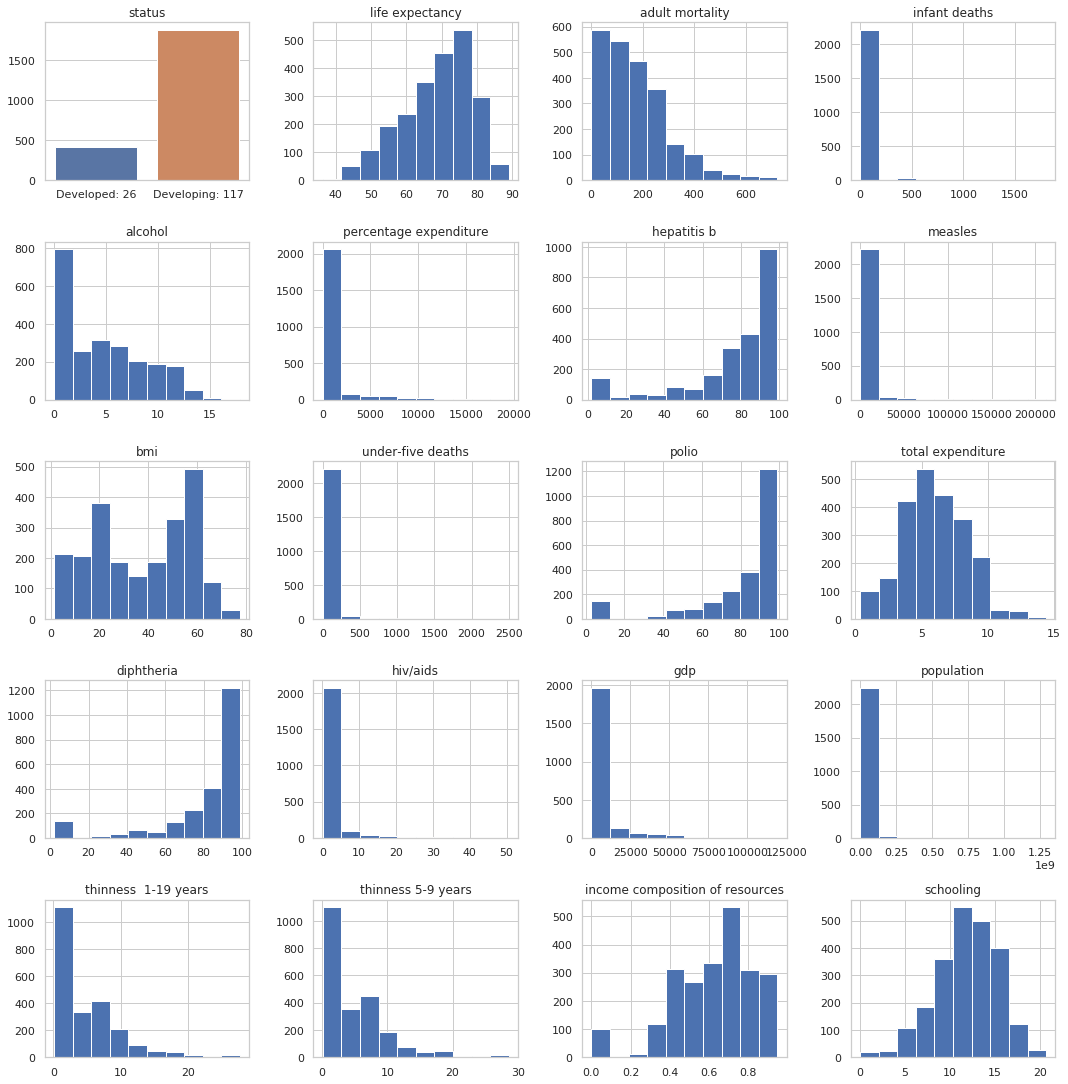

In [465]:
# Number of rows
row = life.shape[1]//4.1 + 1

plt.figure(figsize=(15,3*row))
i = 1
for name in life.columns[2:]:
    if life[name].nunique() < 3:
        plt.subplot(row, 4, i)
        ratio = life.groupby(name).size()/life.groupby(name).size().sum()
        ax = sns.barplot(x=life.groupby(name).count().index, y=life.groupby(name).size())
        ax.set_title(f"{name}")
        plt.xticks(ticks=[0,1], labels=[f'{nuf.index[0]}: {nuf[0]}',f'{nuf.index[1]}: {nuf[1]}'])
        plt.xlabel('')
        i+=1
    else:
        plt.subplot(row, 4, i)
        plt.hist(life[name])
        plt.title(name)
        i+=1
        
plt.tight_layout()
plt.show()

In [466]:
life.groupby('status').mean()

,year,life expectancy,adult mortality,infant deaths,alcohol,percentage expenditure,hepatitis b,measles,bmi,under-five deaths,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
status,,,,,,,,,,,,,,,,,,,,
Developed,2007.5,79.27476,80.692308,0.692308,10.052885,3125.403562,84.001051,573.766827,52.070192,0.884615,93.956731,7.316322,93.834135,0.100000,21920.352299,6.830053e+06,1.346394,1.327885,0.852339,15.858413
Developing,2007.5,66.32281,190.235043,41.477564,3.503235,320.394111,76.463861,2985.087607,34.164391,57.670406,78.177350,5.677783,78.324786,2.489209,3161.822782,1.406028e+07,5.674683,5.751881,0.566229,10.963034


> From the first plot we see a large disparity between the number of 'Developed' and 'Developing' countries. From the grouped dataframe below the plots, we can see that there is a large disparity between developed and developing countries with nearly all the variables. I anticipate that this feature will play a large role for any future models. To confirm its significance, we run a t-test below.

>There are also several non-normally distributed variables. Below, we'll plot each variable as a log(x + 1) transformation to account for the several zero values contained in the data (log(0) = NaN). This will return a zero value for all our current values of zero (log(0 + 1) = 0).

In [468]:
# Determining the significance status on life expectancy 

a = life.loc[life.status == 'Developed']['life expectancy']
b = life.loc[life.status == 'Developing']['life expectancy']

stats.ttest_ind(a, b)

Ttest_indResult(statistic=28.25487737613872, pvalue=6.718707213963153e-151)

> With a p-value < 0.05, we know that the difference in life expectancy between developed and developing countries is significant.

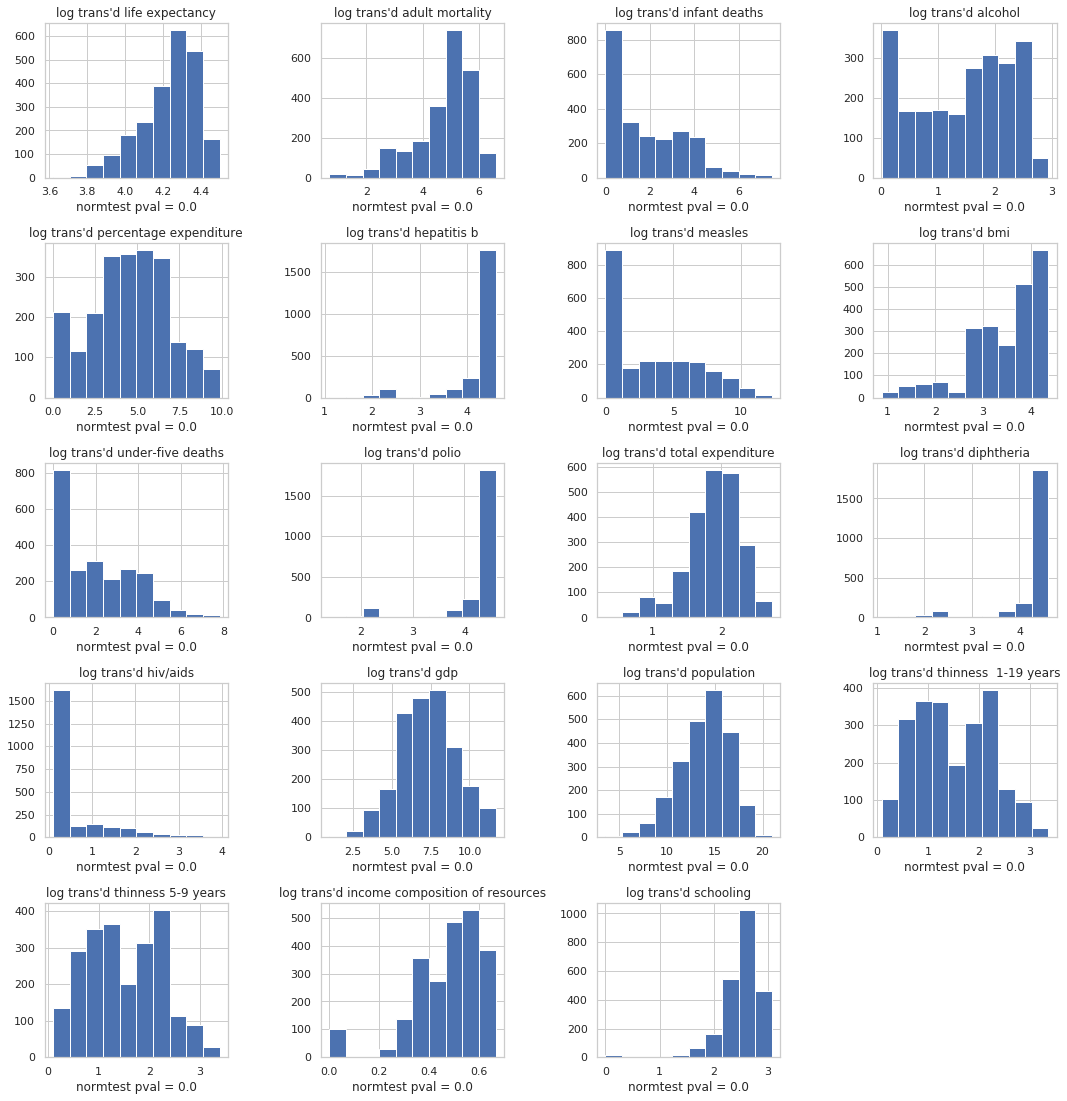

In [469]:
# Number of rows
row = life.shape[1]//4.1 + 1

plt.figure(figsize=(15,3*row))
i = 1
for name in life.columns[3:]:
    norm_stats = normaltest(np.log(life[name] + 1))
    plt.subplot(row, 4, i)
    plt.hist(np.log(life[name] + 1), bins=10)
    plt.title(f'log trans\'d {name}')
    plt.xlabel(f'normtest pval = {round(norm_stats[1],2)}')
    i+=1
        
plt.tight_layout()
plt.show()

> Even after the log transformations, all but the 'population' variables are still statistically different from the normal distribution. However, these transformations might still be useful. If we see that the distribution of a variable more closely resembles the normal distribution after a transformation, it could still be helpful even if it's not *exactly* normal.

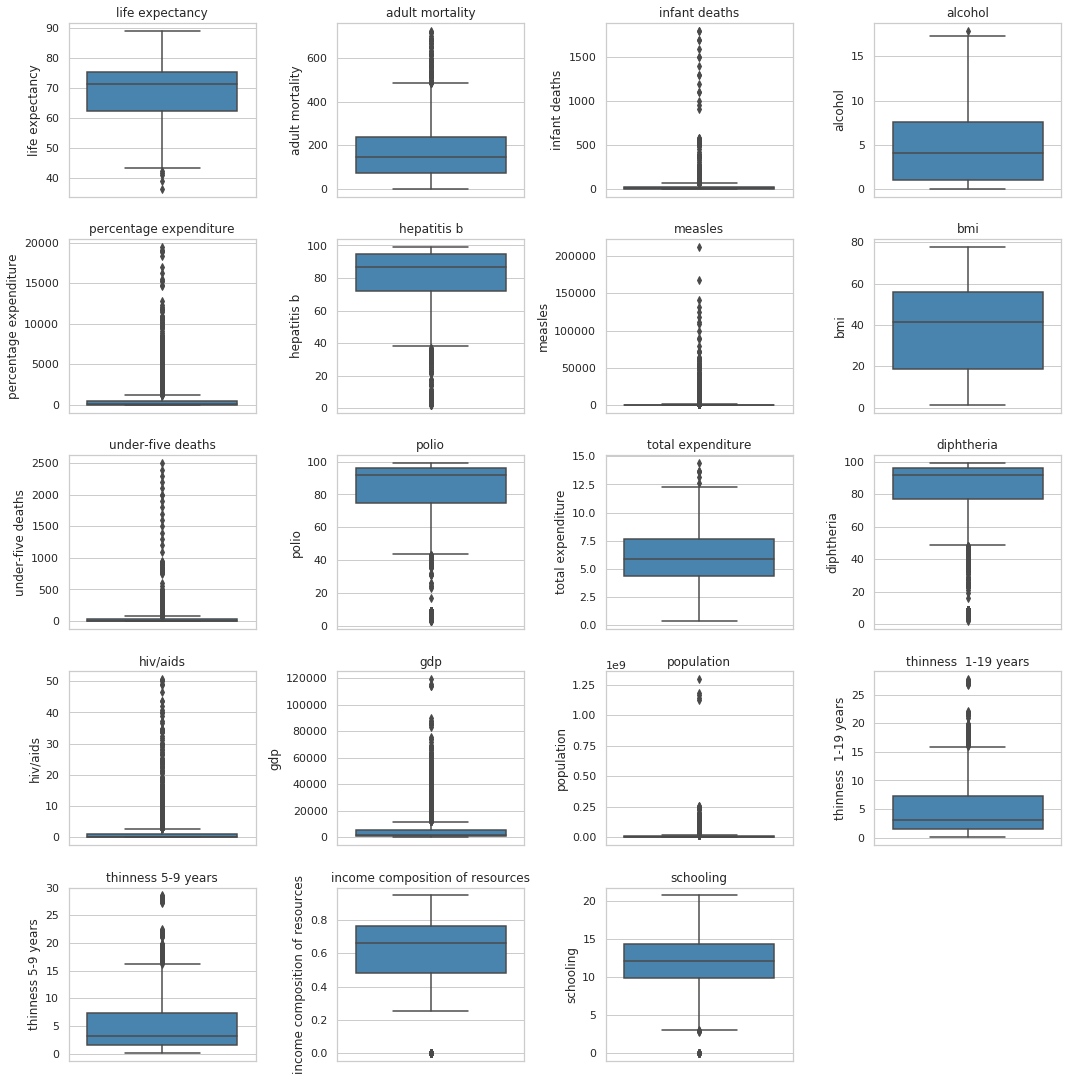

In [470]:
# Number of rows
row = life.shape[1]//4.1 + 1

plt.figure(figsize=(15,3*row))
i = 1
for name in life.columns[3:]:
        plt.subplot(row, 4, i)
        ax = sns.boxplot(x=life[name], orient='v', palette="Blues_d")
        ax.set_title(f"{name}")
        plt.xlabel('')
        i+=1
plt.tight_layout()
plt.show()

> The non-normally distributed variables are also showing large ranges of outlier values. However, I'm concerned that tampering with these outliers might lose some important information as some countries might really have extreme values for some of these variables relative to other countries. Also, outliers are supposed to be rare. The sheer range of outliers within some of these variables makes me suspicious. Below, we'll use a statistical method to see just how extreme some of these outliers are.

In [471]:
for name in life.columns[3:]:
    z_scores = zscore(life["bmi"])
    for threshold in range(3,4):
        print("# of outliers for {} @ threshold {}: {}".format(name, threshold, len((np.where(z_scores > threshold)[0]))))
        print('-'*30)

# of outliers for life expectancy @ threshold 3: 0
------------------------------
# of outliers for adult mortality @ threshold 3: 0
------------------------------
# of outliers for infant deaths @ threshold 3: 0
------------------------------
# of outliers for alcohol @ threshold 3: 0
------------------------------
# of outliers for percentage expenditure @ threshold 3: 0
------------------------------
# of outliers for hepatitis b @ threshold 3: 0
------------------------------
# of outliers for measles @ threshold 3: 0
------------------------------
# of outliers for bmi @ threshold 3: 0
------------------------------
# of outliers for under-five deaths @ threshold 3: 0
------------------------------
# of outliers for polio @ threshold 3: 0
------------------------------
# of outliers for total expenditure @ threshold 3: 0
------------------------------
# of outliers for diphtheria @ threshold 3: 0
------------------------------
# of outliers for hiv/aids @ threshold 3: 0
----------

> When we apply statistical methods, we actually come to see that none of the values, for any variable, fall outside of three standard deviations of their respective means. Due to the large ampunt of extreme values as well as the fact that noe of them fall outside of the 99.7% of observations that would be present if the variables were normally distributed, I've elected not to tamper with any of the outlier values visible in the boxplots.

### Now we examine trends in entry errors.
If we select almost any country at random, and examine it's data alone, well notice that several of the columns show wide swings in values from year to year. For some of these variables, e.g. 'measles', the values might actually fluctuate form year to year, but for others, like 'population' we know that some of these fluctuations cannot be legitimate. Take Nigeria, for example.

In [472]:
life[life.country=='Nigeria']["population"]

1893      1223529.0
1894    125463434.0
1895     12866671.0
1896    131972533.0
1897    135393616.0
1898    138939478.0
1899     14261494.0
1900     14641724.0
1901      1534739.0
1902     15442181.0
1903    158578261.0
1904     16287776.0
1905    167297284.0
1906     17182933.0
1907      1764652.0
1908    181181744.0
Name: population, dtype: float64

> According to the current data, the population of Nigeria is fluctuating hundreds of millions of people from one year to the next. However, if you multiply some of these values by 10, until they all fall within the hundreds of millions range, then what you notice is a steady increase in population from year to year. I Googled the population of Nigeria, so I was able to verify that the population is supposed to be somewhere in the hundreds of millions, but in the interest of time, I need to find a way to ensure which number range each country falls into without having to Google each and every one of them. Also, without the assistance of Google, I would have no reason to believe that Nigeria's population falls into the hundreds of millions, as some values indicate, any more than it does in the tens of millions, as other values indicate. Looking at other countries, it appears that there is a similar, and consistent, erroneous data entry method being applied to population data entries. To address this issue, I'm creating a hot-deck, reference population dataframe that will be used for population comparisons and adjustments.

In [473]:
import requests

url = 'https://photius.com/rankings/population/population_2012_0.html'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[-1]
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,Rank,NaN,Country,Value,NaN,Date of Info
2,1,.,China,1343239923,NaN,Jul 2012 est.
3,2,.,India,1205073612,NaN,Jul 2012 est.
4,3,.,United States,313847465,NaN,Jul 2012 est.


In [474]:
# Re-formatting the dataframe to only include country and population data
df['COUNTRY'] = df['Unnamed: 2']
df['POPULATION'] = df['Unnamed: 3']

del df['Unnamed: 0']
del df['Unnamed: 1']
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
del df['Unnamed: 5']

df.dropna(inplace=True)
df.drop([1], inplace=True)

df['POPULATION'] = df['POPULATION'].astype(int)
df.set_index('COUNTRY', inplace=True)
df = df.rename(index={'Cape Verde': 'Cabo Verde', 
                      'Burma':'Myanmar',
                      'Russia':'Russian Federation',
                      'Syria':'Syrian Arab Republic'})
df.head()

,POPULATION
COUNTRY,
China,1343239923
India,1205073612
United States,313847465
Indonesia,248216193
Brazil,205716890


> Now we have a population reference dataframe that we can use to multiply or, if needed, divide population values by a factor of ten, until all the population values fall within the proper number range. We'll create a function to do just that.

In [475]:
# Creating a function to adjust population figures, specifically

def popularizer(nation):
        # Assign the original population figures 
    series = life.loc[life.country==nation, 'population']
    for i in series:
        j = i
            # Assign the reference population value
        value = df.loc[nation, 'POPULATION']
            # Adjusting the length of the erroneous values to match the reference value
        while len(str(int(i))) != len(str(value)):
                # Increasing or decreasing the value closer to the reference value by multiples of 10
            if len(str(int(i))) < len(str(value)):
                i *= 10
            else:
                i /= 10
        series = series.replace(j,i)
    return series

In [476]:
# Adjusting the population figures from their previous decimal point errors, calling upon the 
# 'popularizer' function

for name in life.country.unique():
    life.loc[life.country==name, 'population'] = popularizer(name)

In [477]:
# Checking Nigerian values to see if the correction was applied.
life[life.country=='Nigeria']["population"]

1893    122352900.0
1894    125463434.0
1895    128666710.0
1896    131972533.0
1897    135393616.0
1898    138939478.0
1899    142614940.0
1900    146417240.0
1901    153473900.0
1902    154421810.0
1903    158578261.0
1904    162877760.0
1905    167297284.0
1906    171829330.0
1907    176465200.0
1908    181181744.0
Name: population, dtype: float64

> It worked! Now Nigeria is showing steady growth from year to year. The numbers actually make sense now. There are also some other variables that seem to have the same erroneous data entry method. We'll address those next.

In [478]:
# Creating a function to fix the lengths (missing zeros) of data point values

def data_fix(nation, column):
        # Assign the erroneous figures 
    series = life.loc[life.country==nation, column]
    for i in series:
        j = i
            # Assign the reference population value
        value = series.max()
            # Adjusting the length of the erroneous values to match the reference value
        while value/i > 7 & len(str(int(value))) > len(str(int(i))):
            if i == 0:
                break
            else:
                # Increasing the value closer to the reference value by multiples of 10
                i *= 10
        series = series.replace(j,i)
    return series

In [479]:
# Adjusting the the remaining figures from their previous decimal point errors, calling upon the 
# 'data_fix' function

for name in life.country.unique():
    for column in ['adult mortality','infant deaths','hepatitis b','measles',
                   'bmi','under-five deaths','polio','diphtheria','gdp']:
        life.loc[life.country==name, column] = data_fix(name, column)

In [480]:
# Create a dummy variable for the variable 'status' for examination in the following correlation heatmap
life['dummy_status'] = pd.get_dummies(life.status, drop_first=True)

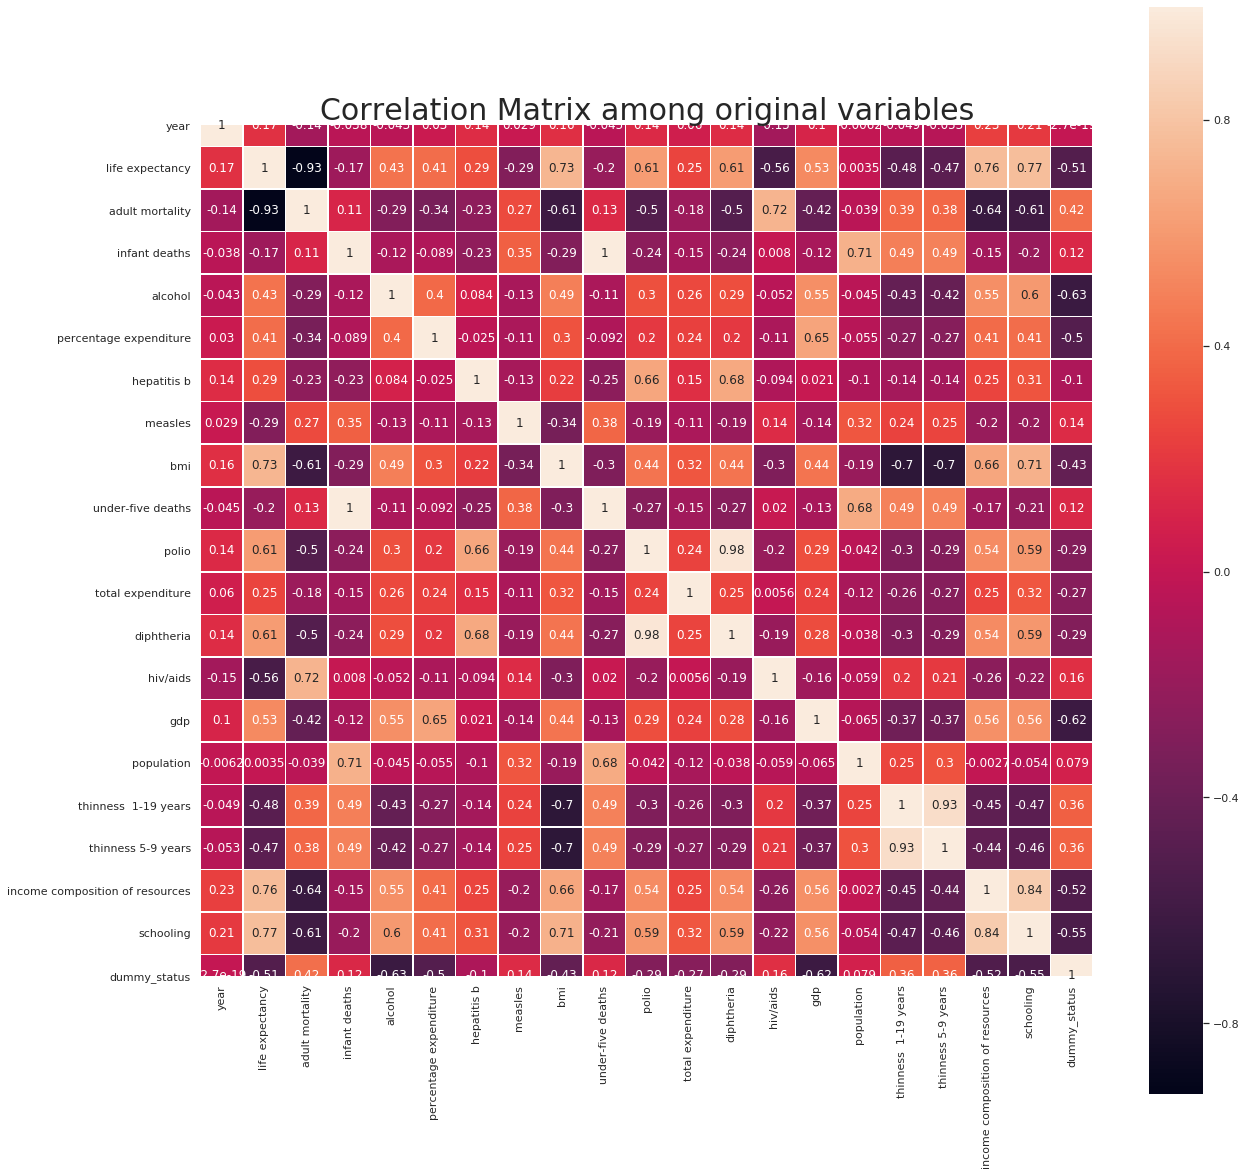

In [481]:
plt.figure(figsize=(20,20))
sns.heatmap(life.corr(), square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix among original variables", fontsize=30)
plt.show()

> Out target varianble 'life expectancy' has some strong correlations, both positive and negative, with multiple other variables.

# Feature Engineering

In [484]:
# Create a new df
life_exp = pd.DataFrame()

# Create the log transformed population column for normalization of population column (see plots above)
life['log_population'] = np.log(life.population)
life_exp = pd.concat([life_exp, life[['country','life expectancy','year','log_population']]], axis=1)
life_exp.head(3)

,country,life expectancy,year,log_population
0,Afghanistan,54.8,2000,17.195675
1,Afghanistan,55.3,2001,17.205466
2,Afghanistan,56.2,2002,16.905640


### Bodyweight

In [485]:
from sklearn.decomposition import PCA
# Capture 99% of the variance among combined variables
pca = PCA(n_components=0.99)

# Compile weight related variables
life2 = life[['bmi', 'thinness  1-19 years', 'thinness 5-9 years']]

weight_pca = pca.fit_transform(life2)

print(f'PCA explained Variance Ratio: {pca.explained_variance_ratio_}\n')
print(f'Feature importance per PCA component:\n{abs(pca.components_)}')

PCA explained Variance Ratio: [0.94037454 0.0553825 ]

Feature importance per PCA component:
[[0.96284321 0.18875044 0.19314817]
 [0.27006083 0.67375604 0.68783715]]


> Since the first component explains over 94% of the variance among the combined variables, and since `bmi` explains almost all of the first component, we can conclude that among these three variables relating to weight, `bmi` is the most important. However, the two 'thinness' variables weigh heavier on the second component.

In [486]:
# Add the principal components to our life_exp df
life_exp['weight_pca_1'] = weight_pca[:,0]
life_exp['weight_pca_2'] = weight_pca[:,1]

del life2

life_exp.head(3)

,country,life expectancy,year,log_population,weight_pca_1,weight_pca_2
0,Afghanistan,54.8,2000,17.195675,-27.087928,-11.294272
1,Afghanistan,55.3,2001,17.205466,-26.645726,-11.389782
2,Afghanistan,56.2,2002,16.905640,-29.581717,0.573532


### Youth Deaths

In [487]:
pca = PCA(n_components=0.99)

# Compile youth death related variables
life2 = life[['infant deaths', 'under-five deaths', 'measles']]

youth_death = pca.fit_transform(life2)

print(f'PCA explained Variance Ratio: {pca.explained_variance_ratio_}\n')
print(f'Feature importance per PCA component:\n{abs(pca.components_)}')

PCA explained Variance Ratio: [0.9999288]

Feature importance per PCA component:
[[0.0019097  0.00277927 0.99999431]]


> Among both youth death variables, `measles` explains most of the one and only component necessary to explain 99% of the variance for the combined variables.

In [488]:
life_exp['youth_death'] = youth_death

del life2

life_exp.head(3)

,country,life expectancy,year,log_population,weight_pca_1,weight_pca_2,youth_death
0,Afghanistan,54.8,2000,17.195675,-27.087928,-11.294272,-3192.105205
1,Afghanistan,55.3,2001,17.205466,-26.645726,-11.389782,-962.117884
2,Afghanistan,56.2,2002,16.905640,-29.581717,0.573532,-7238.082201


### Adult Death

In [489]:
pca = PCA(n_components=0.99)

# Compile adult death related variables
life2 = life[['adult mortality', 'hiv/aids']]

adult_death = pca.fit_transform(life2)

print(f'PCA explained Variance Ratio: {pca.explained_variance_ratio_}\n')
print(f'Feature importance per PCA component:\n{abs(pca.components_)}')

PCA explained Variance Ratio: [0.99903812]

Feature importance per PCA component:
[[0.99947364 0.03244152]]


> Among both adult death variables, `adult mortality` explains most of the one and only component necessary to explain 99% of the variance for the combined variables.

In [490]:
life_exp['adult_death'] = adult_death

del life2

life_exp.head(3)

,country,life expectancy,year,log_population,weight_pca_1,weight_pca_2,youth_death,adult_death
0,Afghanistan,54.8,2000,17.195675,-27.087928,-11.294272,-3192.105205,113.539779
1,Afghanistan,55.3,2001,17.205466,-26.645726,-11.389782,-962.117884,108.542411
2,Afghanistan,56.2,2002,16.905640,-29.581717,0.573532,-7238.082201,92.550833


### Illness

In [491]:
pca = PCA(n_components=0.99)

# Compile illness related variables
life2 = life[['hepatitis b', 'polio','diphtheria']]

illness = pca.fit_transform(life2)

print(f'PCA explained Variance Ratio: {pca.explained_variance_ratio_}\n')
print(f'Feature importance per PCA component:\n{abs(pca.components_)}')

PCA explained Variance Ratio: [0.83626008 0.15650379]

Feature importance per PCA component:
[[0.60542749 0.54809915 0.5771004 ]
 [0.79566661 0.43438266 0.42216862]]


> Although all the variables each explain a lot of each component, `hepatitis b` explains the most for them both.

In [492]:
life_exp['illness_pca_1'] = illness[:,0]
life_exp['illness_pca_2'] = illness[:,1]


del life2

life_exp.head(3)

,country,life expectancy,year,log_population,weight_pca_1,weight_pca_2,youth_death,adult_death,illness_pca_1,illness_pca_2
0,Afghanistan,54.8,2000,17.195675,-27.087928,-11.294272,-3192.105205,113.539779,80.907252,-36.873398
1,Afghanistan,55.3,2001,17.205466,-26.645726,-11.389782,-962.117884,108.542411,69.078830,-29.091338
2,Afghanistan,56.2,2002,16.905640,-29.581717,0.573532,-7238.082201,92.550833,66.194002,-28.186116


### Wealth Indicators

In [493]:
pca = PCA(n_components=0.99)

# Compile wealth related variables
life2 = life[['gdp', 'alcohol','percentage expenditure','income composition of resources',
              'schooling','dummy_status','total expenditure']]

wealth = pca.fit_transform(life2)

print(f'PCA explained Variance Ratio: {pca.explained_variance_ratio_}\n')
print(f'Feature importance per PCA component:\n{abs(pca.components_)}')

PCA explained Variance Ratio: [0.99198973]

Feature importance per PCA component:
[[9.96942188e-01 1.21703865e-04 7.81424798e-02 6.49625126e-06
  1.06591172e-04 1.31456491e-05 3.09316785e-05]]


> `gdp` is the *clear* explanatory power among the wealth indicator variables needed to explain the one component necessary to explain 99% of the variance for the combined features.

In [494]:
life_exp['wealth'] = wealth

del life2

life_exp.head(3)

,country,life expectancy,year,log_population,weight_pca_1,weight_pca_2,youth_death,adult_death,illness_pca_1,illness_pca_2,wealth
0,Afghanistan,54.8,2000,17.195675,-27.087928,-11.294272,-3192.105205,113.539779,80.907252,-36.873398,-10829.147239
1,Afghanistan,55.3,2001,17.205466,-26.645726,-11.389782,-962.117884,108.542411,69.078830,-29.091338,-10826.207507
2,Afghanistan,56.2,2002,16.905640,-29.581717,0.573532,-7238.082201,92.550833,66.194002,-28.186116,-10755.580336


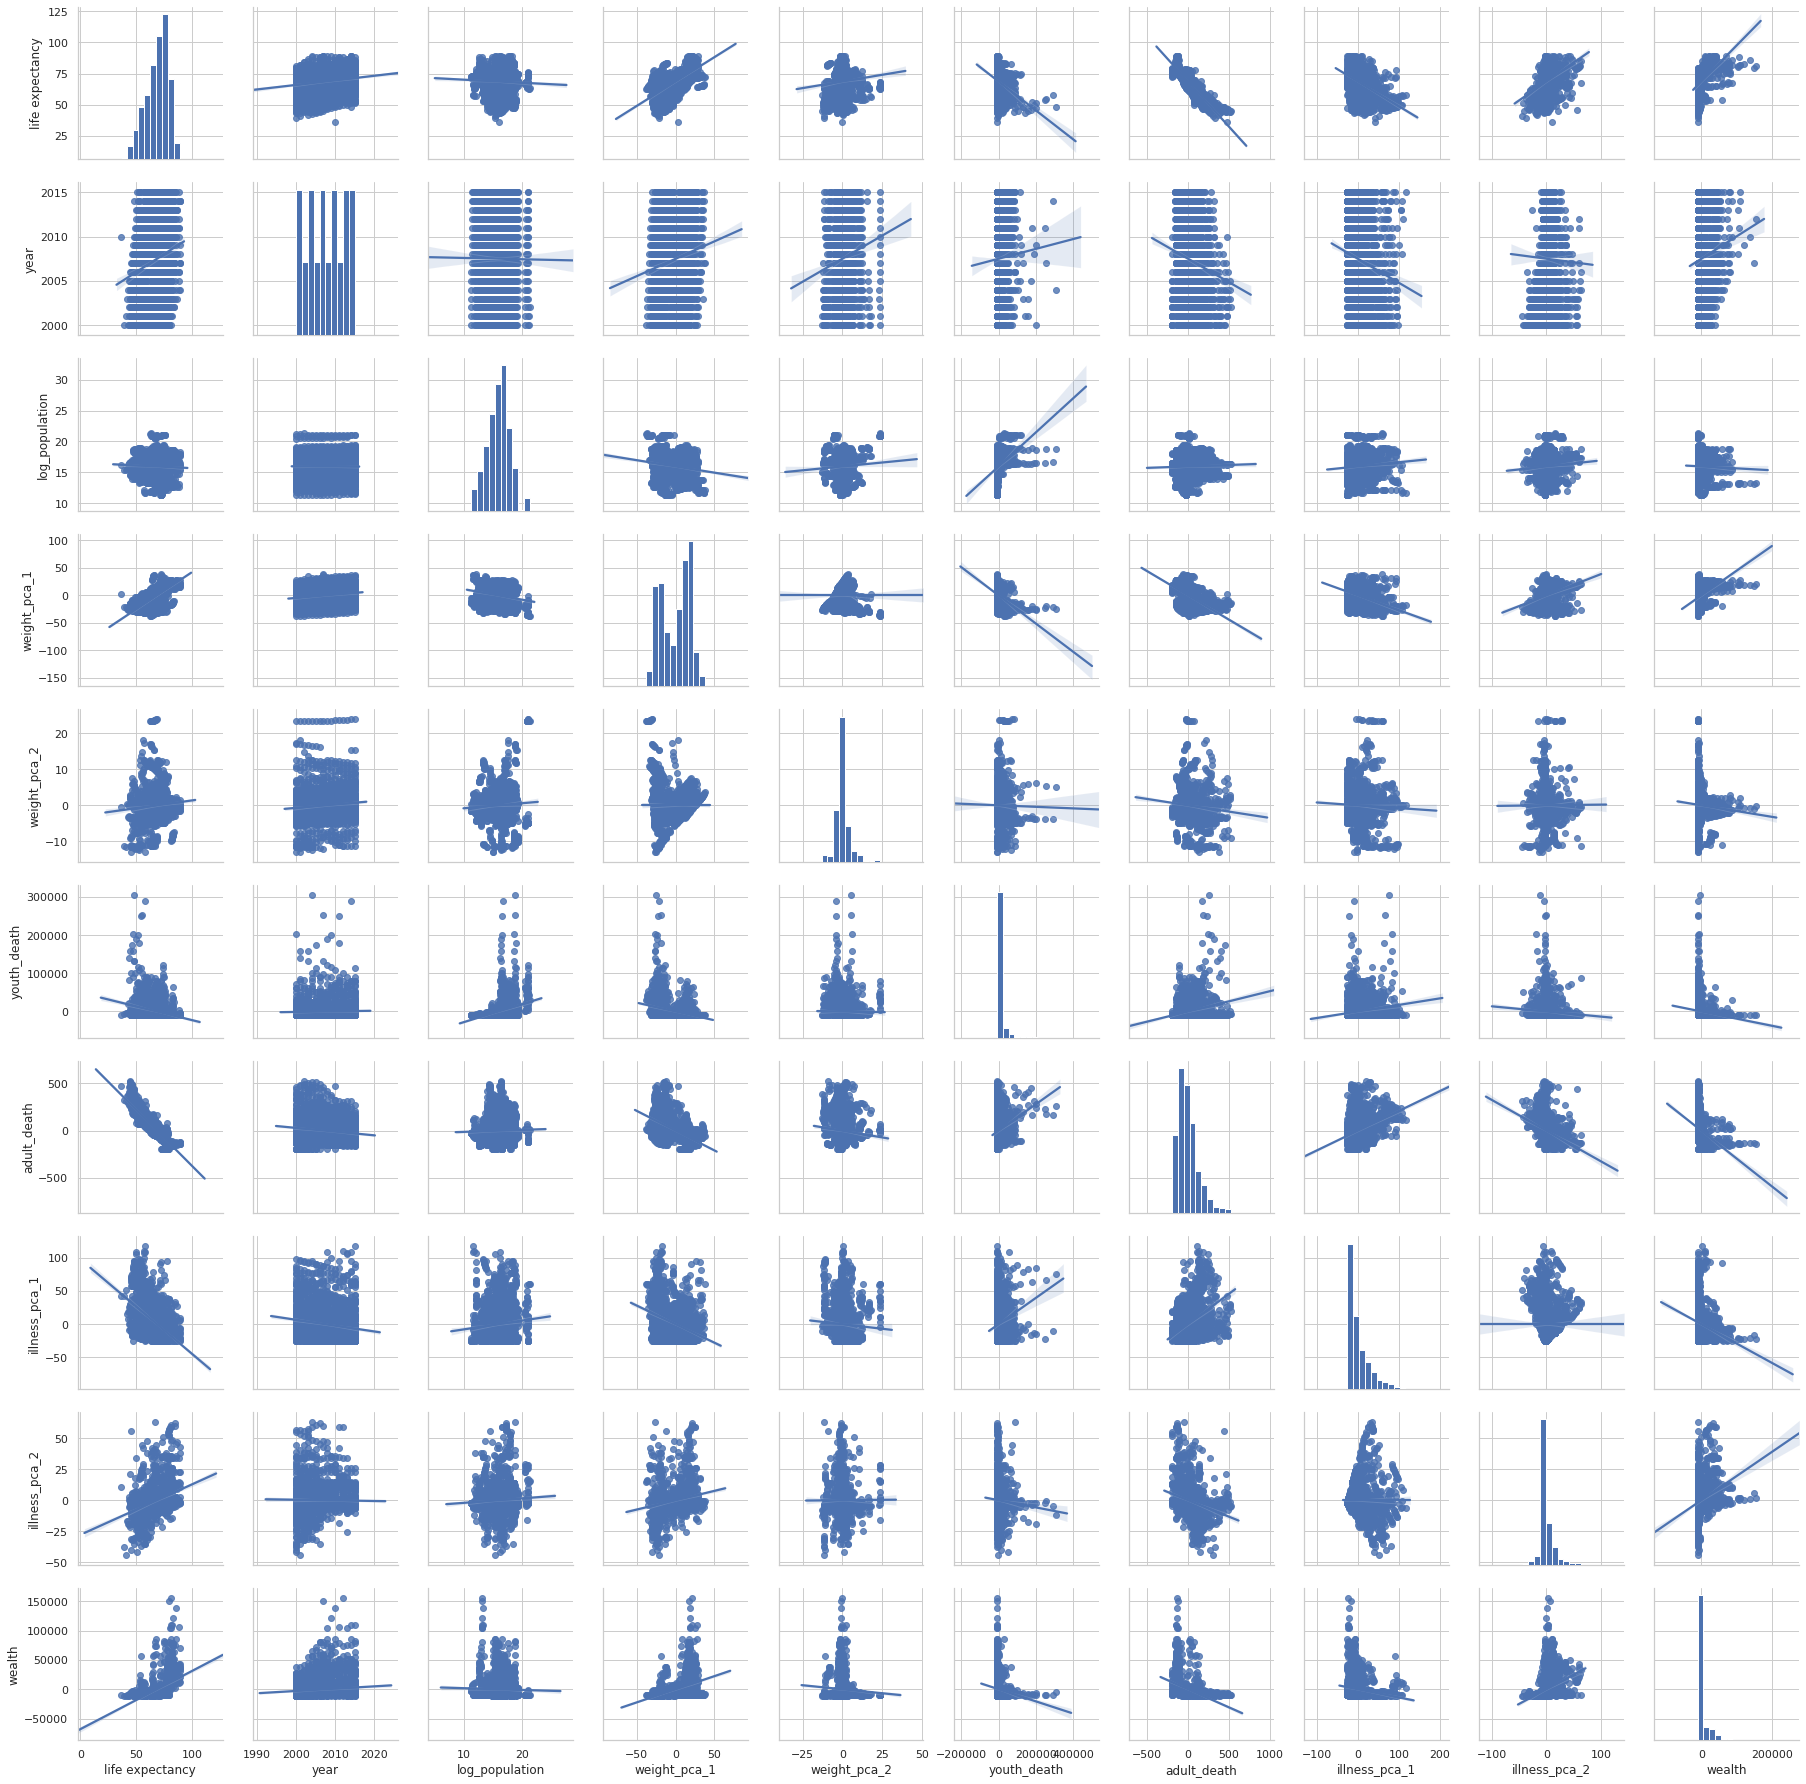

In [422]:
# with regression
sns.pairplot(life_exp, kind="reg")
plt.show()

> The fitted lines indicate the relationship each of the variables/components have with one another. As it relates to `life expectancy`, we can see that life expectancy goes up as `wealth` increases, as weight increases (especially `weight_pca_1`, influenced mostly by `bmi`), and seems to have some strange positive correlation with `illness_pca_2`. Since `illness_pca_1` explains almost 84% of the variance among the illness variables, and since the relationship between `life expectancy` and `illness_pca_1` is negative, it still stands to reason that illness has a negative affect on life expectancy (namely `hepatitis b`) even if `illness_pca_2` is capturing some positive correlation. `life expectancy` also increases as the years go by.

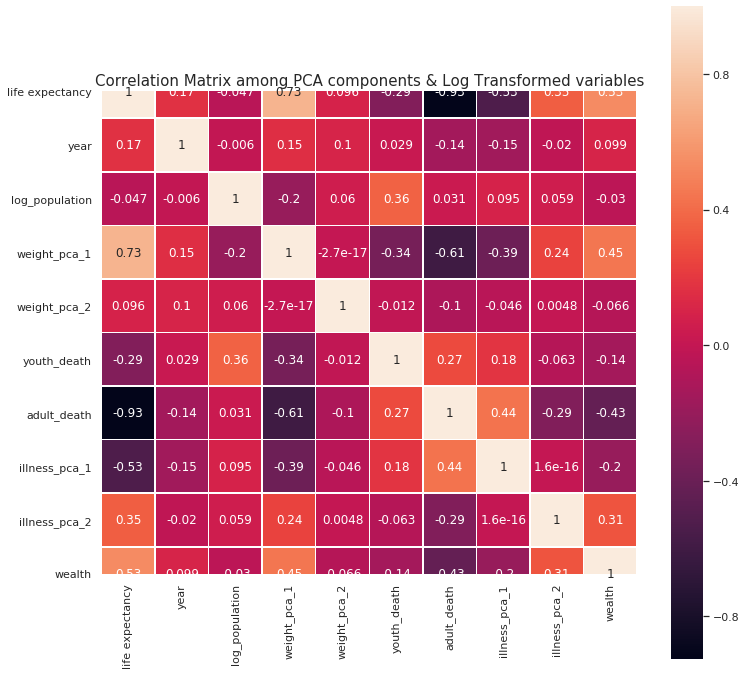

In [442]:
plt.figure(figsize=(12,12))
sns.heatmap(life_exp.corr(), square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix among PCA components & Log Transformed variables", fontsize=15)
plt.show()

# Conclusion
> Above, we see which variables correlate with `life expectancy` the most. `adult_death` has the greatest negative correlation, itself influenced overwhelmingly by the `adult mortality` variable. Also, `weight_pca_1`, influenced mostly by the `bmi` variable has the strongest positive correlation with `life expectancy`. It's hard to tell what contributes to adult mortality from this data, aside from hiv/aids. If one were to gain next-best-move, actionable insights from this analysis, it might be to find ways to reduce the hiv/aids infection rates. Such a person might also consider finding ways to increase bodyweight, perhaps via increased food consumption or food quality. Those with the inclination or expertise could also do well to find ways to reduce illness overall, especially among the youth (see the first correlation heatmap above). All in all, I'm not sure we've discovered any new targets that society at large hasn't already discovered, but it's nice to see some validation for continued global efforts to close the life expectancy gap.